## 0. Setup
Import required libraries and configure logging settings

In [8]:
import os
import sys
import warnings
import logging

# Suppress TF logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# Setting up GPU use explicitly to prevent initialization warnings
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import tensorflow as tf

# Suppress warning messages
logging.getLogger('tensorflow').setLevel(logging.ERROR)
tf.get_logger().setLevel(logging.ERROR)

import numpy as np
import cv2
import matplotlib.pyplot as plt

## 1. 2D Convolution Implementation
Implement convolution operation from scratch using NumPy and test it with a sample matrix

In [9]:
def convolution2d(image: np.ndarray, kernel: np.ndarray, stride: int = 1) -> np.ndarray:
    """
    Implement 2D convolution operation from scratch using NumPy

    Args:
        image(np.ndarray): Input image/matrix
        kernel (np.ndarray): Convolution kernel/filter
        stride (int): Stride value, default is 1
        
    Returns:
        np.ndarray: Resulting convolved matrix
    """
    # Get dimensions
    image_height, image_width = image.shape
    kernel_height, kernel_width = kernel.shape

    # Calculate output dimensions
    output_height = ((image_height - kernel_height) // stride) + 1
    output_width = ((image_width - kernel_width) // stride) + 1

    # Initialize output matrix
    output = np.zeros((output_height, output_width))

    # Perform convolution
    for i in range(0, image_height - kernel_height + 1, stride):
        for j in range(0, image_width - kernel_width + 1, stride):
            # Extract the current window
            current_window = image[i:i+kernel_height, j:j+kernel_width]
            # Perform element-wise multiplication and sum
            output[i//stride, j//stride] = np.sum(current_window * kernel)

    return output

# Test our convolution function with an example
test_matrix = np.array([
    [45, 63, 27, 90, 34],
    [36, 18, 81, 9, 87],
    [9, 54, 72, 99, 56],
    [83, 23, 12, 43, 54],
    [27, 8, 19, 67, 69]
])

# Create a 3x3 box filter kernel (all elements = 1/9)
box_kernel = np.ones((3, 3)) / 9

# Apply convolution
result = convolution2d(test_matrix, box_kernel)

def display_convolution_result(original, kernel, result):
    """
    Display the original matrix, kernel, and convolution result.
    """
    print("Original Matrix:")
    print(original)
    print("\nKernel:")
    print(kernel)
    print("\nConvolution Result:")
    print(result)

# Test our display function
display_convolution_result(test_matrix, box_kernel, result)

Original Matrix:
[[45 63 27 90 34]
 [36 18 81  9 87]
 [ 9 54 72 99 56]
 [83 23 12 43 54]
 [27  8 19 67 69]]

Kernel:
[[0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]]

Convolution Result:
[[45.         57.         61.66666667]
 [43.11111111 45.66666667 57.        ]
 [34.11111111 44.11111111 54.55555556]]


## 2. Loading and Examining Image
Load an image using cv2 and examine its properties, including color channel visualization

Image shape: (600, 600, 3)
image data type: uint8
Min pixel value: 0
Max pixel value: 255


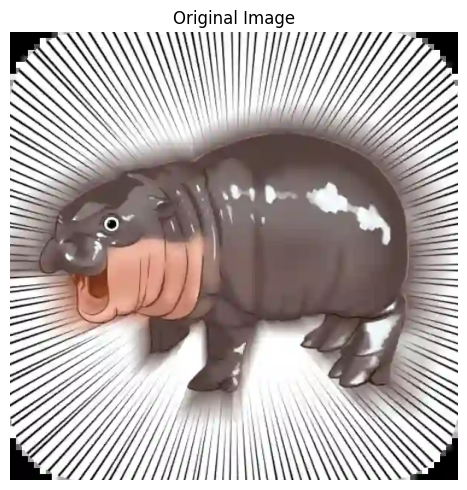

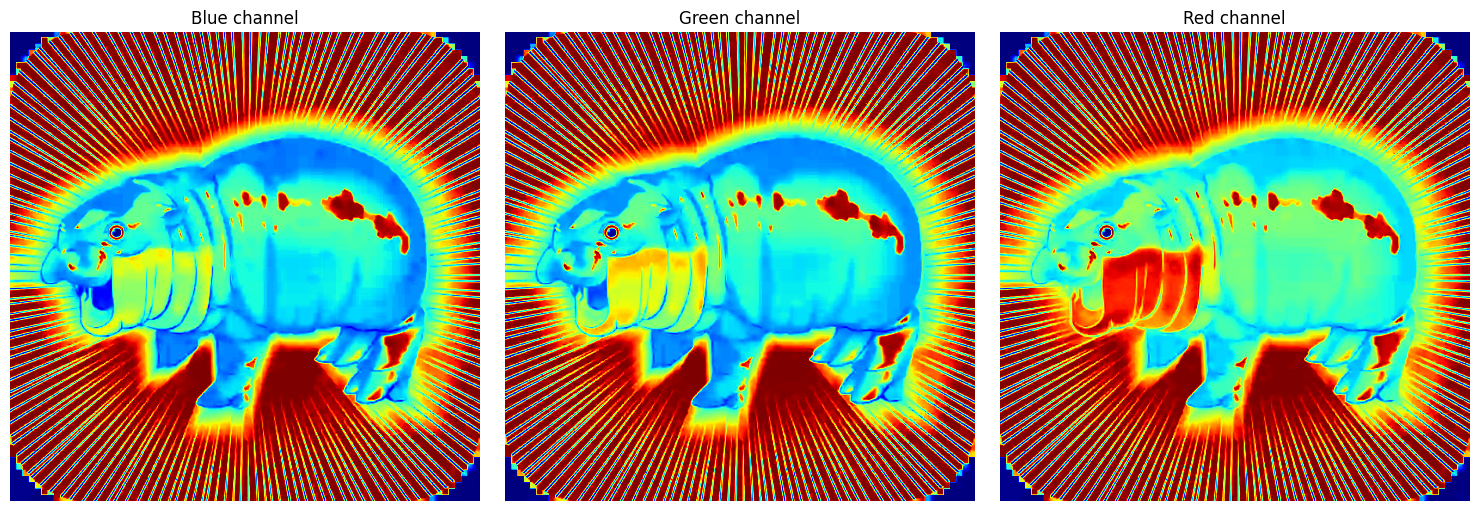

In [10]:
# Load the image
img = cv2.imread('./data/moo_deng.jpg')

def display_image(images, titles=None, figsize=(15, 5), cmaps=None):
    """
    Display multiple images side by side with matplotlib.
    
    Args:
        images: Single image or list of images
        titles: Optional list of titles for each image
        figsize: Figure size (width, height)
        cmaps: Single colormap or list of colormaps for single-channel images
    """
    # Convert single image to list
    if not isinstance(images, list):
        images = [images]
    
    # Create default titles if none provided
    if titles is None:
        titles = [f'Image {i+1}' for i in range(len(images))]
    elif isinstance(titles, str):
        titles = [titles]
    
    # Handle colormap specification
    if cmaps is None:
        cmaps = ['gray'] * len(images)
    elif isinstance(cmaps, str):
        cmaps = [cmaps] * len(images)
    
    # Create figure with subplots
    fig, axes = plt.subplots(1, len(images), figsize=figsize)
    # Convert single axis to list for consistent indexing
    if len(images) == 1:
        axes = [axes]
    
    # Display each image
    for ax, img, title, cmap in zip(axes, images, titles, cmaps):
        if len(img.shape) == 3:
            # Convert BGR to RGB for display
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            ax.imshow(img_rgb)
        else:
            # If grayscale, use specified colormap
            ax.imshow(img, cmap=cmap)
        ax.set_title(title)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Let's examine the image properties
print(f"Image shape: {img.shape}")
print(f"image data type: {img.dtype}")
print(f"Min pixel value: {img.min()}")
print(f"Max pixel value: {img.max()}")

# Display original image
display_image(img, "Original Image")

# Display color channels 
b, g, r = cv2.split(img)
display_image([b, g, r], 
             titles=['Blue channel', 'Green channel', 'Red channel'], 
             figsize=(15, 5),
             cmaps='jet')

## 3. TensorFlow Conversion
Convert image from NumPy array to TensorFlow tensor and verify the conversion

In [11]:
# Convert our numpy array (image) to a TensorFlow tensor
img_tf = tf.convert_to_tensor(img)

# Let's verify the conversion
print(f"Original numpy array type: {type(img)}")
print(f"Original numpy array shape: {img.shape}")
print(f"Original numpy array dtype: {img.dtype}")
print("\n")
print(f"TensorFlow tensor type: {type(img_tf)}")
print(f"TensorFlow tensor shape: {img_tf.shape}")
print(f"TensorFlow tensor dtype: {img_tf.dtype}")

Original numpy array type: <class 'numpy.ndarray'>
Original numpy array shape: (600, 600, 3)
Original numpy array dtype: uint8


TensorFlow tensor type: <class 'tensorflow.python.framework.ops.EagerTensor'>
TensorFlow tensor shape: (600, 600, 3)
TensorFlow tensor dtype: <dtype: 'uint8'>


## 4. Image Filtering
Implement and apply various filters:
- Box filter (uniform blur)
- Gaussian filter (smooth blur)
- Unsharp masking (sharpening)

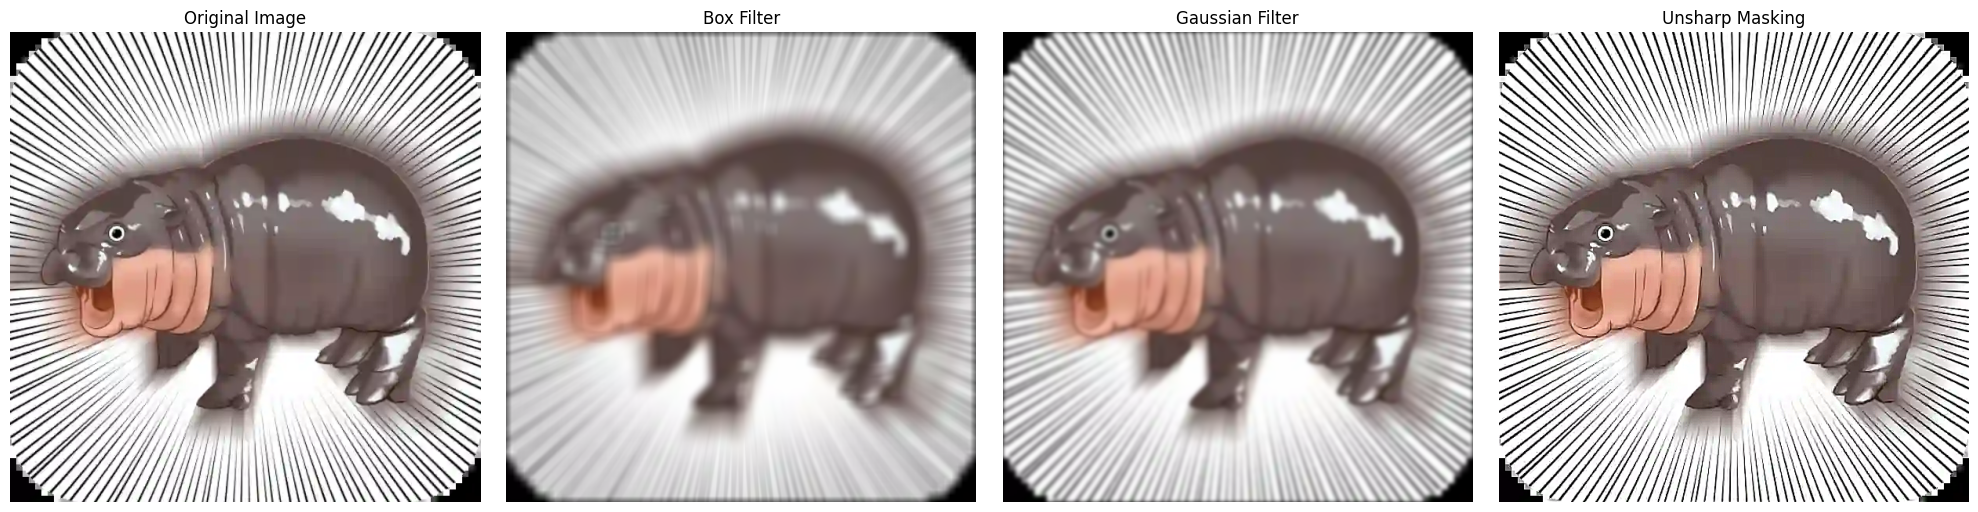

In [12]:
def create_box_kernel(size=3):
    """
    Create a box filter kernel using TensorFlow.
    """
    kernel = tf.ones((size, size)) / (size * size)
    kernel = tf.expand_dims(tf.expand_dims(kernel, -1), -1)
    return kernel

def create_gaussian_kernel(size=3, sigma=1.0):
    """
    Create a Gaussian kernel using TensorFlow.

    Args:
        size (int): Kernel size (should be odd)
        sigma (float): Standard deviation of the Gaussian distribution
    """
    # Create a coordinate grid
    ax = tf.range(-size // 2 + 1.0, size // 2 + 1.0)
    xx, yy = tf.meshgrid(ax, ax)

    # Calculate the Gaussian kernel
    kernel = tf.exp(-(xx**2 + yy**2)/ (2.0 * sigma**2))

    # Normalize the kernel
    kernel = kernel / tf.reduce_sum(kernel)

    # Expand dimensions for broadcasting
    kernel = tf.expand_dims(tf.expand_dims(kernel, -1), -1)
    return kernel

def apply_filter(image, kernel):
    """
    Apply a filter kernel to an image using TensorFlow convolution.
    Handles both grayscale and color images.
    """
    # Add batch dimension if not present
    if len(image.shape) == 3:
        image = tf.expand_dims(image, 0)

    # Convert to float32 for computation
    image = tf.cast(image, tf.float32)

    # Apply filter to each channel separately
    channels = tf.unstack(image, axis=-1)
    filtered_channels = []

    for channel in channels:
        # Add channel dimension
        channel = tf.expand_dims(tf.expand_dims(channel, 0), -1)
        # Apply convolution
        filtered = tf.nn.conv2d(channel, kernel, strides=1, padding='SAME')
        filtered_channels.append(tf.squeeze(filtered))

    # Stack channels back together
    filtered_image = tf.stack(filtered_channels, axis=-1)

    # Remove batch dimension and convert back to uint8
    filtered_image = tf.squeeze(filtered_image)
    fitlered_image = tf.clip_by_value(filtered_image, 0, 255)
    filtered_image = tf.cast(filtered_image, tf.uint8)

    return filtered_image

def unsharp_mask(image, kernel_size=3, amount=1.0):
    """
    Apply unsharp masking to an image.

    Args:
        image: Input image tensor
        kernel_size: Size of the Gaussian kernel for blurring
        amount: Strength of the sharpening effect
    """
    # Create Gaussian kernel for blurring
    gaussian_kernel = create_gaussian_kernel(kernel_size, sigma=1.0)

    # Blur the image
    blurred = apply_filter(image, gaussian_kernel)

    # Calculate the mask (detail)
    mask = tf.cast(image, tf.float32) - tf.cast(blurred, tf.float32)

    # Add weighted mask to original image
    sharpened = tf.cast(image, tf.float32) + amount * mask

    # Clip values and convert back to uint8
    sharpened = tf.clip_by_value(sharpened, 0, 255)
    sharpened = tf.cast(sharpened, tf.uint8)

    return sharpened

# Apply all filters to our image
box_filtered = apply_filter(img_tf, create_box_kernel(15))
gaussian_filtered = apply_filter(img_tf, create_gaussian_kernel(15, 2.5))
sharpened = unsharp_mask(img_tf, 15, 1.5)

display_image([img_tf.numpy(), box_filtered.numpy(), gaussian_filtered.numpy(), sharpened.numpy()],
             titles=["Original Image", "Box Filter", "Gaussian Filter", "Unsharp Masking"],
             figsize=(20, 5))

## 5. (Optional) Edge Detection
Implement Sobel operator for edge detection:
- Horizontal edge detection
- Vertical edge detection
- Combined edge magnitude

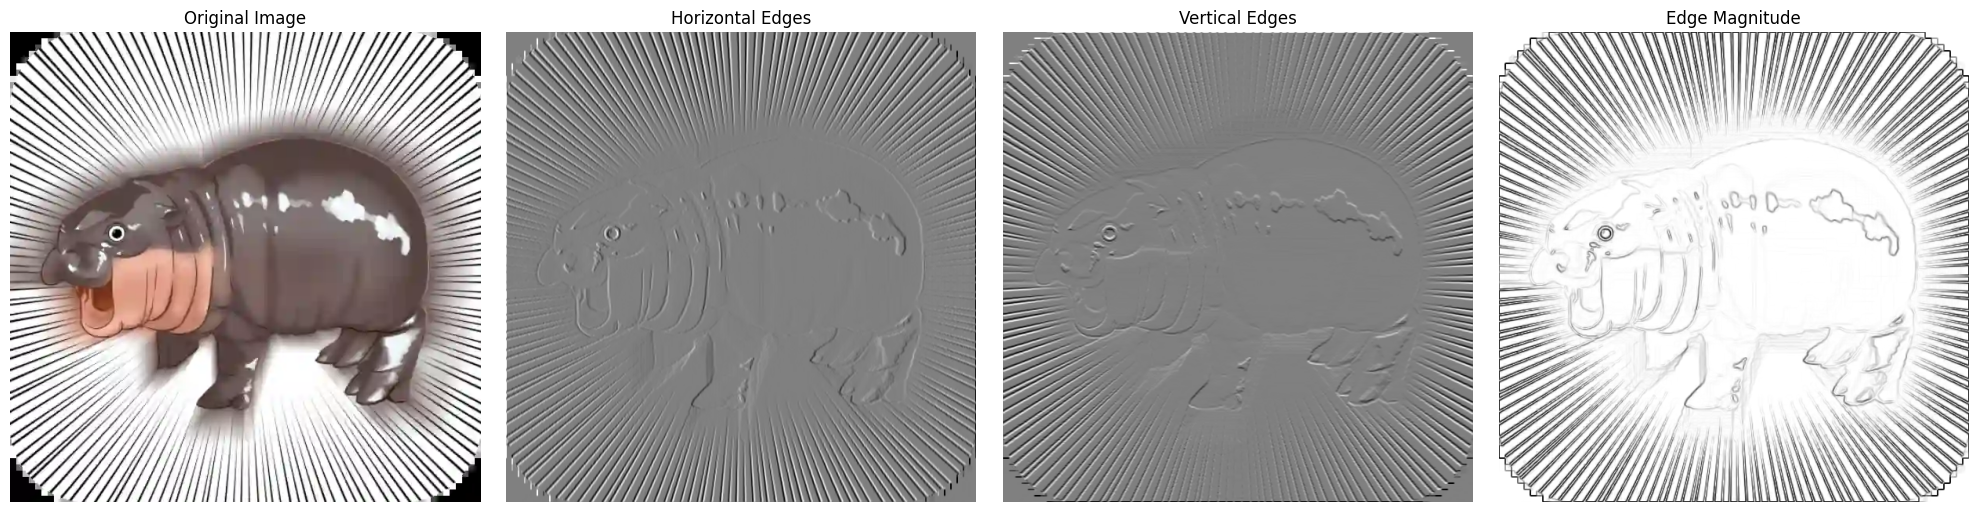

In [13]:
def create_sobel_kernels():
    """
    Create Sobel kernels for x and y directions using TensorFlow.
    """
    # Sobel kernel for horizontal edges
    kernel_x = tf.constant([
        [-1, 0, 1],
        [-2, 0, 2],
        [-1, 0, 1]
    ], dtype=tf.float32)
    
    # Sobel kernel for vertical edges
    kernel_y = tf.constant([
        [-1, -2, -1],
        [0, 0, 0],
        [1, 2, 1]
    ], dtype=tf.float32)
    
    # Expand dimensions for TF convolution
    kernel_x = tf.expand_dims(tf.expand_dims(kernel_x, -1), -1)
    kernel_y = tf.expand_dims(tf.expand_dims(kernel_y, -1), -1)
    
    return kernel_x, kernel_y

def detect_edges(image):
    """
    Detect edges in an image using the Sobel operator.

    Args:
        image: Input image tensor (BGR format)
    Returns:
        edge_magnitude: Compbined edge magnitude
        edge_x: Horizontal edges
        edge_y: Vertical edges
    """
    # Convert to grayscale if color image
    if len(image.shape) == 3:
        # Convert BGR to grayscale using standard weights
        image = tf.cast(image, tf.float32)
        grayscale = 0.114 * image[..., 0] + 0.587 * image[..., 1] + 0.299 * image[..., 2]
        grayscale = tf.expand_dims(grayscale, -1)

    # Add batch dimension
    grayscale = tf.expand_dims(grayscale, 0)

    # Get Sobel kernels
    kernel_x, kernel_y = create_sobel_kernels()

    # Apply convolution for both directions
    edge_x = tf.nn.conv2d(grayscale, kernel_x, strides=1, padding='SAME')
    edge_y = tf.nn.conv2d(grayscale, kernel_y, strides=1, padding='SAME')

    # Calculate edge magnitude
    edge_magnitude = tf.sqrt(tf.square(edge_x) + tf.square(edge_y))

    # Normalize to 0-255 range
    edge_magnitude = tf.squeeze(edge_magnitude)
    edge_magnitude = (edge_magnitude - tf.reduce_min(edge_magnitude)) / (tf.reduce_max(edge_magnitude) - tf.reduce_min(edge_magnitude)) * 255

    # Convert back to uint8
    edge_magnitude = tf.cast(edge_magnitude, tf.uint8)

    return edge_magnitude, tf.squeeze(edge_x), tf.squeeze(edge_y)

# Apply edge detection to our image
edge_magnitude, edge_x, edge_y = detect_edges(img_tf)

# Display the results
display_image([img_tf.numpy(), edge_x.numpy(), edge_y.numpy(), edge_magnitude.numpy()],
             titles=["Original Image", "Horizontal Edges", "Vertical Edges", "Edge Magnitude"],
             figsize=(20, 5),
             cmaps=[None, 'gray', 'gray', 'gray_r'])

## 6. Image Normalization
Implement and compare different normalization techniques:
- Min-max normalization
- Standardization (mean=0, std=1)

Visualize pixel value distributions for each method


Original Image Statistics:
Mean: 167.918
Std Dev: 76.226
Min: 0.000
Max: 255.000

Min-Max Normalized Image Statistics:
Mean: 0.659
Std Dev: 0.299
Min: 0.000
Max: 1.000

Standardized Image Statistics:
Mean: 0.000
Std Dev: 1.000
Min: -2.203
Max: 1.142


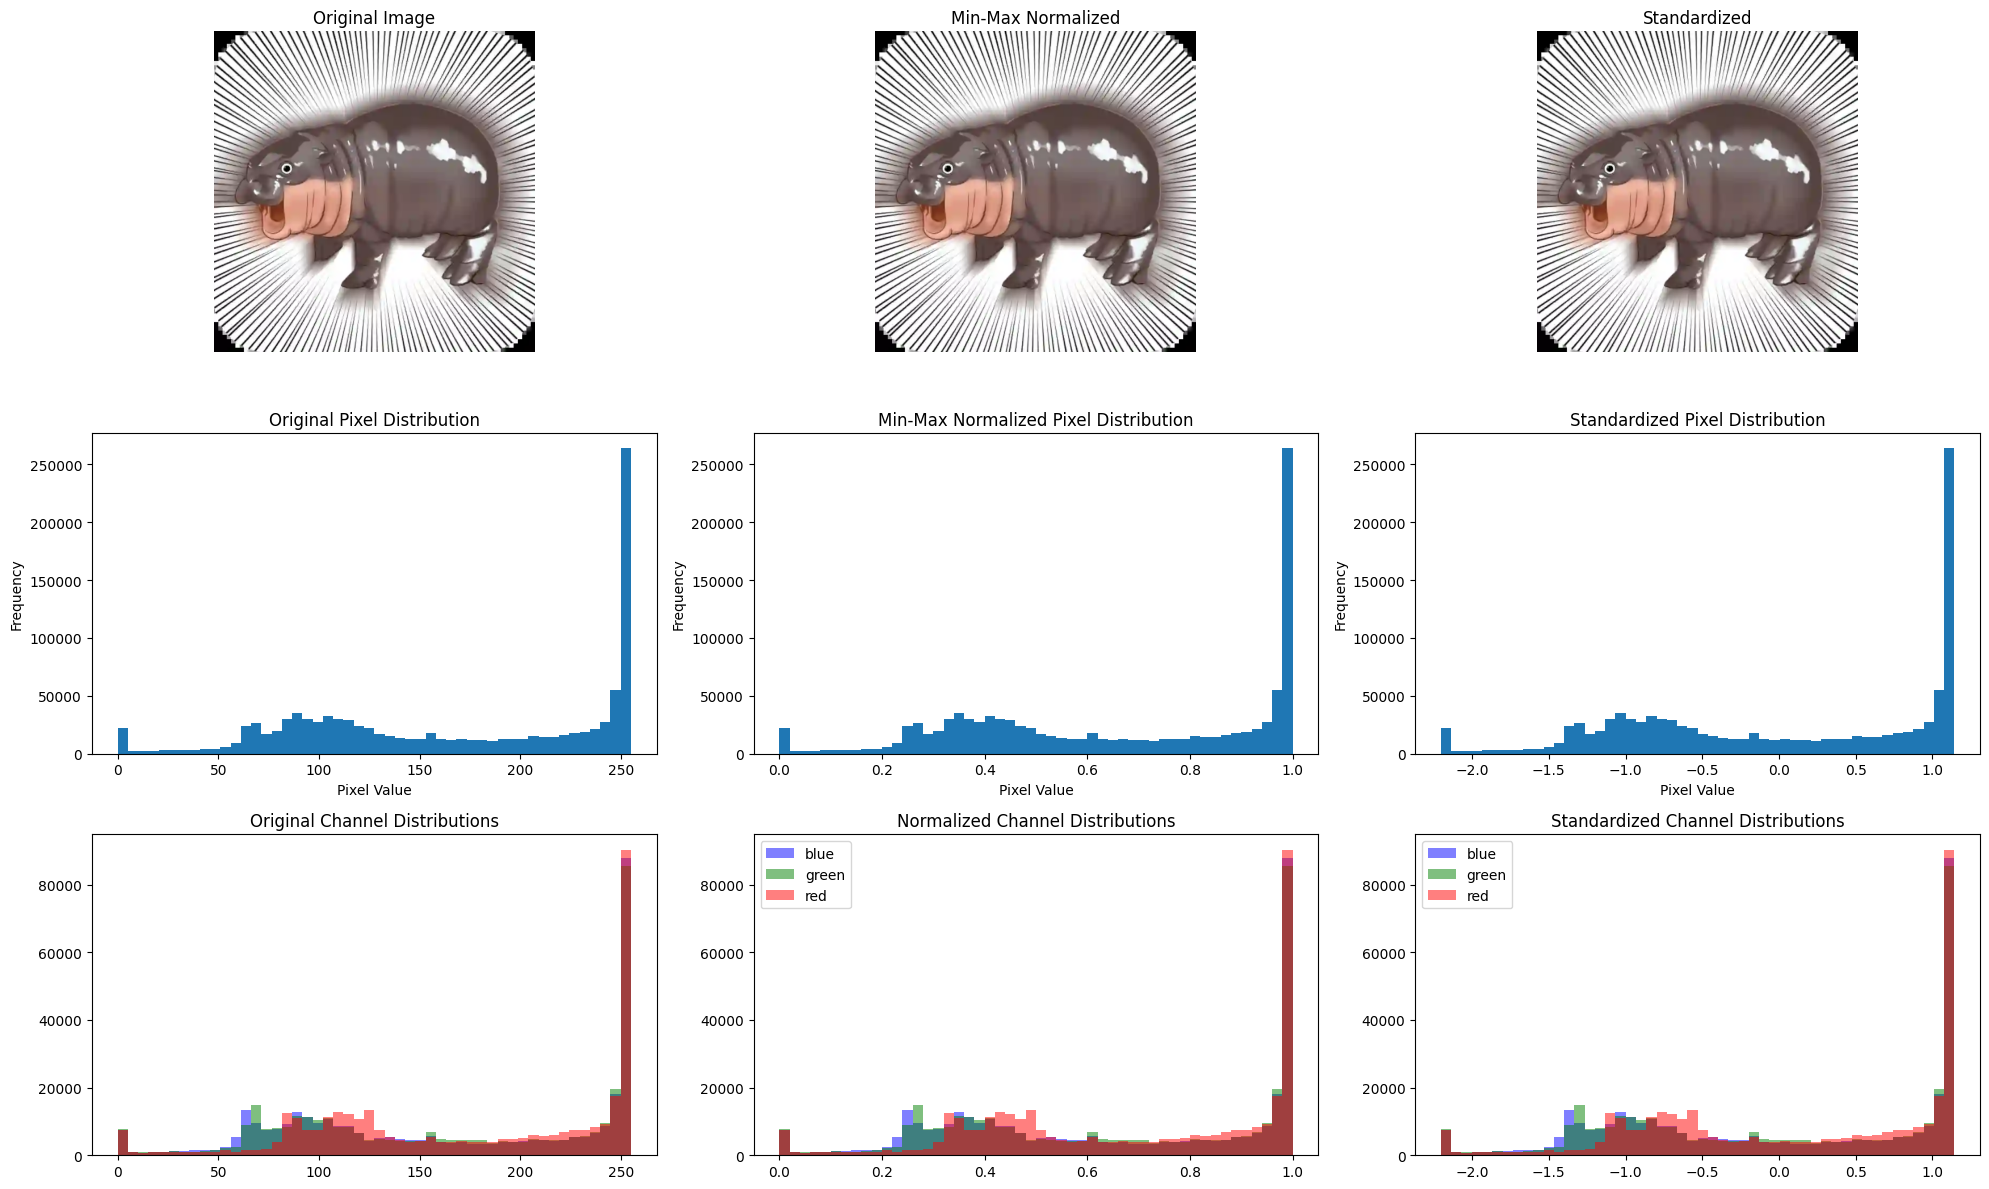

In [14]:
def min_max_normalize(image):
    """
    Perform min-max normalization on an image.
    Scales values to range [0, 1].
    """
    # Convert to float32 for calculations
    image = tf.cast(image, tf.float32)

    # Calculate min and max values
    min_val = tf.reduce_min(image)
    max_val = tf.reduce_max(image)

    # Normalize to [0, 1] range
    normalized = (image - min_val) / (max_val - min_val)

    return normalized

def standardize(image):
    """
    Perform standardization of an image.
    Centers the data around mean 0 with standard deviation 1.
    """
    # Convert to float32 for calculations
    image = tf.cast(image, tf.float32)

    # Calculate mean and standard deviation
    mean = tf.reduce_mean(image)
    std = tf.math.reduce_std(image)

    # Standardize 
    standardized = (image - mean) / std

    return standardized

# Function to print statistics about an image
def print_image_stats(image, name):
    """Print basic statistics about an image."""
    print(f"\n{name} Statistics:")
    print(f"Mean: {tf.reduce_mean(image):.3f}")
    print(f"Std Dev: {tf.math.reduce_std(image):.3f}")
    print(f"Min: {tf.reduce_min(image):.3f}")
    print(f"Max: {tf.reduce_max(image):.3f}")

# Get original image statistics
print_image_stats(tf.cast(img_tf, tf.float32), "Original Image")

# Apply normalizations
normalized_img = min_max_normalize(img_tf)
standardized_img = standardize(img_tf)

# Get statistics for processed images
print_image_stats(normalized_img, "Min-Max Normalized Image")
print_image_stats(standardized_img, "Standardized Image")

# Function to visualize pixel value distributions
def plot_distribution(image, title):
    """Plot histogram of pixel values."""
    values = tf.reshape(image, [-1]) # Flatten the image
    plt.hist(values.numpy(), bins = 50)
    plt.title(title)
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')

# Create visualization
plt.figure(figsize=(20,12))

# Original image and its distribution
plt.subplot(331)
plt.imshow(cv2.cvtColor(img_tf.numpy().astype(np.uint8), cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis('off')

plt.subplot(334)
plot_distribution(tf.cast(img_tf, tf.float32), "Original Pixel Distribution")

# Min-max normalized image and its distribution
plt.subplot(332)
plt.imshow(cv2.cvtColor((normalized_img.numpy() * 255).astype(np.uint8), cv2.COLOR_BGR2RGB))
plt.title("Min-Max Normalized")
plt.axis('off')

plt.subplot(335)
plot_distribution(normalized_img, "Min-Max Normalized Pixel Distribution")

# Standardized image and its distribution
# For display, we need to rescale standardized values to 0-255 range
standardized_display = (standardized_img - tf.reduce_min(standardized_img)) / (tf.reduce_max(standardized_img) - tf.reduce_min(standardized_img))

plt.subplot(333)
plt.imshow(cv2.cvtColor((standardized_display.numpy() * 255).astype(np.uint8), cv2.COLOR_BGR2RGB))
plt.title("Standardized")
plt.axis('off')

plt.subplot(336)
plot_distribution(standardized_img, "Standardized Pixel Distribution")

# Add color channel distributions on the bottom row
plt.subplot(337)
for i, color in enumerate(['blue', 'green', 'red']):
    values = tf.reshape(tf.cast(img_tf[..., i], tf.float32), [-1])
    plt.hist(values.numpy(), bins=50, alpha=0.5, label=color, color=color)
plt.title("Original Channel Distributions")

plt.subplot(338)
for i, color in enumerate(['blue', 'green', 'red']):
    values = tf.reshape(normalized_img[..., i], [-1])
    plt.hist(values.numpy(), bins=50, alpha=0.5, label=color, color=color)
plt.title("Normalized Channel Distributions")
plt.legend()

plt.subplot(339)
for i, color in enumerate(['blue', 'green', 'red']):
    values = tf.reshape(standardized_img[..., i], [-1])
    plt.hist(values.numpy(), bins=50, alpha=0.5, label=color, color=color)
plt.title("Standardized Channel Distributions")
plt.legend()

plt.tight_layout()
plt.show()
